# Fine-tuning Model Image Captioning (VIT + BioMedBERT)

## Install and Import Libraries

In [ ]:
! pip install sentencepiece
! pip install transformers
! pip install datasets
! pip install sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 12.7 MB/s eta 0:00:00


In [ ]:
import datasets
import transformers
import pandas as pd
import torch
from torch.utils.data.dataset import Dataset
from pathlib import Path
from transformers import TrainerCallback
from copy import deepcopy
from PIL import Image
import cv2
import numpy as np
import math
from tokenizers import ByteLevelBPETokenizer
from transformers import BertConfig
from transformers import BertForMaskedLM
from transformers import BertTokenizerFast
from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer
from transformers import BertTokenizer
from transformers import DataCollatorForLanguageModeling
from transformers import default_data_collator
from transformers import ViTFeatureExtractor, ViTModel
from transformers import VisionEncoderDecoderModel
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
from textwrap import wrap
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from transformers import pipeline
import datetime
import numpy as np
from torch.utils.data import random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
import unicodedata
import json
import nltk
from tensorflow.keras.utils import plot_model
import textwrap

nltk.download('stopwords')

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from huggingface_hub import login

login("[TOKEN]")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## Utility Functions

In [ ]:
def tokenize_seq(sent,tokenizer,max_length):
  '''
    Tokenize the sentence with respect to the sent argument and the tokenizer
  '''
  return tokenizer('<sos>'+ sent + '<eos>', truncation=True, max_length=max_length, padding="max_length")

def format_time(elapsed):
    '''
      Calculate the time difference
    '''
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

def model_prediction(my_model, image, max_length=50):
    '''
    Return the estimation of the model with respect of the feature extractor and the tokenizer
    '''
    result = tokenizer.decode(
        my_model.generate(
            feature_extractor(image, return_tensors="pt", do_normalize=True, image_mean=[0.5, 0.5, 0.5]).pixel_values,
            max_length=max_length 
        )[0]
    )
    result = result.replace("<s>", "").replace("</s>", "").replace("<unk>", "").replace("<pad>", "").strip()
    return result


def display_score_images(df,my_model,n_limit=3):
  '''
    Return n original images & titles as well as the predictions with respect to the model and the dataframe
  '''
  temp_index_list = df.index.tolist()
  rnumbers = random.sample(range(0,len(temp_index_list)), n_limit)
  my_images = []
  my_titles = []
  my_predictions = []
  for r in rnumbers:
    image = cv2.imread(df.iloc[r]['images'],1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (image_target_size,image_target_size))
    my_images.append(image)
    my_images.append(image)
    my_titles.append(test_df.iloc[r]['captions'])
    my_predictions.append(model_prediction(my_model,image))

  return my_images , my_titles , my_predictions

def display_n_images(im_list, im_title, im_suptitle, n_rows, n_columns):
    '''
    Custom function for displaying images with their titles, adjusted for larger images and wrapped text.
    '''
    fig = plt.figure(figsize=(20, 12 * n_rows))

    plt.subplots_adjust(hspace=0.8)

    for i in range(1, n_columns * n_rows + 1):
        ax = fig.add_subplot(n_rows, n_columns, i)
        ax.imshow(im_list[i - 1])
        if (i - 1) % 2 == 0:
            title = textwrap.fill(im_title[(i - 1) // 2], width=30)
            ax.set_title(title, color='green', fontsize=14, pad=20)
        else:
            cleaned_subtitle = im_suptitle[(i - 1) // 2].replace('[CLS]', '').strip()
            subtitle = textwrap.fill(cleaned_subtitle, width=50)
            ax.set_title(subtitle, color='blue', fontsize=14, pad=20)
        ax.axis('off')

    plt.suptitle('Actual vs Predictions', fontsize=18)
    plt.show()

def display_image(img,my_title=None):
  '''
  Custom function to display single image with its title
  '''
  fig, axes = plt.subplots(1, figsize=(15,15))
  if len(img.shape) == 2 :
    plt.imshow(img,cmap='gray')
  else:
    plt.imshow(img)
  if my_title is not None:
    plt.title(my_title)
  plt.axis('off');

def rmv_empty_images(temp_df,temp_list):
  '''
      According to the list of values and the dataframe,
      remove all the rows within the dataframe
  '''
  if temp_list is None:
    temp_list =  []
    for i,t in enumerate(temp_df['images'].tolist()):
      image = cv2.imread(t)
      try:
          temp_shape = image.shape
      except Exception:
        temp_list.append(t)
        continue
    temp_df = temp_df[~temp_df.images.isin(temp_list)]
    return temp_df
  else:
    temp_df = temp_df[~temp_df.images.isin(temp_list)]
    return temp_df

def find_metrics_history(trainer):
  '''
     According the history of the trainer model, fetch the training as well the validation loss
  '''
  train_loss_list = []
  train_perplexity_list = []
  val_loss_list = []
  val_perplexity_list = []
  for i,t in enumerate(trainer.state.log_history):
    if t.get('train_runtime') == trainer.state.log_history[-1].get('train_runtime'):
      break
    if 'train_loss' in t.keys():
      train_loss_list.append(t.get('train_loss'))
      train_perplexity_list.append(math.exp(t['train_loss']))
    elif 'eval_loss' in t.keys():
      val_loss_list.append(t.get('eval_loss'))
      val_perplexity_list.append(math.exp(t['eval_loss']))
  return train_loss_list , train_perplexity_list , val_loss_list , val_perplexity_list

def transform_df(df):
  '''
    This is the main transformation function of the process.
    First step is to lowercase all the strings, remove punctioations as well
    as the values within the parenthesis
  '''
  df['captions'] = df['captions'].str.lower()
  df['captions'] = df['captions'].apply(
      lambda elem: elem.replace('\n','').strip())
  df['captions'] = df['captions'].apply(
      lambda elem: re.sub("\(.*?\)","()",elem))
  df['captions'] = df['captions'].apply(
      lambda elem:  re.sub("[\(\[].*?[\)\]]", "", elem))
  df['captions'] = df['captions'].apply(
      lambda elem: re.sub(r'[^\w\s]', "", elem))
  return df

def get_ngrams(review, n, g):
    '''
    Return the Top n words according to the size of the n-gram
    '''
    vec = CountVectorizer(ngram_range=(g, g)).fit(review)
    bag_of_words = vec.transform(review)
    sum_words = bag_of_words.sum(axis=0)
    sum_words = np.array(sum_words)[0].tolist()
    words_freq = [(word, sum_words[idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def display_score_images_gr(df,my_model,n_limit=3):
  '''
    Return n original images & titles as well as the predictions with respect to the model and the dataframe
    that contains the gr translations of the original captions.
  '''
  temp_index_list = df.index.tolist()
  rnumbers = random.sample(range(0,len(temp_index_list)), n_limit)
  my_images = []
  my_titles = []
  my_predictions = []
  for r in rnumbers:
    image = cv2.imread(df.iloc[r]['images'],1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMAGE_TARGET_SIZE,IMAGE_TARGET_SIZE))
    my_images.append(image)
    my_images.append(image)
    my_titles.append(df.iloc[r]['captions_gr'] +'\n'+(df.iloc[r]['captions']))
    my_predictions.append(model_prediction(my_model,image))

def create_gr_stopwords(stopwords):
  '''
    Update the nltk greek stopwords with certain words
  '''
  stopwords = set(stopwords.words('greek'))
  new_stopwords = []
  for s in stopwords:
    new_stopwords.append(strip_accents_and_lowercase(s))
  new_stopwords.append('μια')
  new_stopwords.append('μιας')
  new_stopwords.append('μου')
  new_stopwords.append('ενα')
  new_stopwords.append('σας')
  return new_stopwords

def strip_accents_and_lowercase(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn').lower()

def cleansing_col(main_df):
  '''
  invoke the strip_accents_and_lowercase function and
  cleanse the captions_gr column that contains the gr translations
  of the original caption column
  '''
  cleansed_data = []
  for v in main_df['captions_gr'].values:
    new_string = re.sub(r'http\S+', '', v)
    new_string = strip_accents_and_lowercase(new_string)
    new_string = new_string.split(' ')
    new_string = ' '.join(new_string)
    cleansed_data.append(new_string)
  main_df['captions_gr'] = cleansed_data
  return main_df


def validation_score(df):
  '''
   With respect of the dataframe and the model
   return the original captions and the predicted captions
  '''
  true_labels = []
  predicted_labels = []
  for index,record in df.iterrows():
      caption = predict_caption(caption_model, record['images'], tokenizer, max_length, val_features)
      true_labels.append(manipulate_str(record['captions']))
      predicted_labels.append(manipulate_str(caption))
  return predicted_labels , true_labels

def display_score_images_dense(df,my_model,n_limit=3):
  '''
    Return n original images & titles as well as the predictions
    with respect to the model of the Dense + LSTM architecture
  '''
  temp_index_list = df.index.tolist()
  rnumbers = random.sample(range(0,len(temp_index_list)), n_limit)
  my_images = []
  true_labels = []
  predicted_labels = []
  for r in rnumbers:
    image = cv2.imread(df.iloc[r]['images'],1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (image_target_size,image_target_size))
    my_images.append(image)
    my_images.append(image)
    true_labels.append(manipulate_str (df.iloc[r]['captions']))
    caption = predict_caption(my_model,df.iloc[r]['images'], tokenizer, max_length, val_features)
    predicted_labels.append(manipulate_str(caption))
  return my_images , true_labels , predicted_labels

def predict_caption(model, image, tokenizer, max_length, features):
    '''
    With respect to the Dense+LSTM architecture
    return the predicted caption of the model
    '''
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        word = idx_to_word(y_pred, tokenizer)
        if word is None:
            break
        in_text+= " " + word
        if word == 'endseq':
            break
    return in_text

def manipulate_str(my_str):
  '''
  Remove special charactes
  from the my_str argument
  '''
  temp_str = my_str.replace('startseq',"").replace('\n',"").replace('endseq',"")
  temp_str = temp_str.split(' ')
  return (' '.join(temp_str)).strip()

def idx_to_word(integer,tokenizer):
    '''
    With respect to the tokenizer and the token id
    return the respective word
    '''
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None
def make_model_tensors_contiguous(model):
    for name, param in model.named_parameters():
        if not param.data.is_contiguous():
            param.data = param.data.contiguous()

class CustomCallback(TrainerCallback):
    def __init__(self, trainer) -> None:
        super().__init__()
        self._trainer = trainer

    def on_epoch_end(self, args, state, control, **kwargs):
        if control.should_evaluate:
            control_copy = deepcopy(control)
            self._trainer.evaluate(eval_dataset=self._trainer.train_dataset, metric_key_prefix="train")
            return control_copy

### Hyperparameters

In [ ]:
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 5
VAL_EPOCHS = 1
LEARNING_RATE = 1e-4
SEED = 42
MAX_LEN = 128
SUMMARY_LEN = 20
TRAIN_EPOCHS = 5
WEIGHT_DECAY = 0.01
SEED = 42
MAX_LEN = 128
SUMMARY_LEN = 20
BATCH_SIZE= 32
IMAGE_TARGET_SIZE = 224

## Dataset Preparation

In [ ]:
import os
import pandas as pd

dataset_paths = {
    'train': '/kaggle/input/roco-brain/train/kaggle/working/traindata.csv',
    'test': '/kaggle/input/roco-brain/test/kaggle/working/testdata.csv',
    'validation': '/kaggle/input/roco-brain/validation/kaggle/working/validationdata.csv'
}

dfs = {}

for key, path in dataset_paths.items():
    df = pd.read_csv(path)
    df.drop(columns=['Unnamed: 0'], inplace=True)
    df.rename(columns={'name': 'images', 'caption': 'captions'}, inplace=True)
    data_dir = f"/kaggle/input/roco-brain/{key}/kaggle/working/{key}_images/"
    df['images'] = data_dir + df['images']
    dfs[key] = df

train_df = dfs['train']
test_df = dfs['test']
validation_df = dfs['validation']

print("Train DataFrame shape (ROCO Brain):", train_df.shape)

Train DataFrame shape (ROCO Brain): (2874, 3)


In [ ]:
class ROCO_Dataset(Dataset):
    def __init__(self, df, tokenizer,feature_extractor, decoder_max_length=31):
        self.df = df
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.decoder_max_length = decoder_max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df['images'][idx]
        caption = self.df['captions'][idx]

        image = cv2.imread(img_path,1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMAGE_TARGET_SIZE,IMAGE_TARGET_SIZE))

        pixel_values = self.feature_extractor(image, return_tensors="pt",do_normalize = True,
                                              image_mean =[0.5, 0.5, 0.5]).pixel_values

        labels = self.tokenizer(caption, truncation = True,
                                          padding="max_length",
                                          max_length=self.decoder_max_length).input_ids

        labels = [label if label != self.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

## Fine-tuning Decoder BioMedBert

In [ ]:
model = BertForMaskedLM.from_pretrained('microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract')
tokenizer = AutoTokenizer.from_pretrained('microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract', max_len=MAX_LEN)

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/225k [00:00<?, ?B/s]

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.examples = []

        for example in df.values:
            x=tokenizer.encode_plus(example, max_length = MAX_LEN, truncation=True, padding=True)
            self.examples += [x.input_ids]

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        return torch.tensor(self.examples[i])

In [ ]:
train_dataset = CustomDataset(train_df['captions'], tokenizer)
eval_dataset = CustomDataset(validation_df['captions'], tokenizer)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

In [ ]:
model_folder = "BioMedBert"
make_model_tensors_contiguous(model)

training_args = TrainingArguments(
    output_dir=model_folder,
    overwrite_output_dir=True,
    logging_dir="/kaggle/working/BioMedBert/logs",
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    num_train_epochs=50,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=VALID_BATCH_SIZE,
    report_to="none",
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

trainer.add_callback(CustomCallback(trainer))

In [ ]:
trainer.train()

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch,Training Loss,Validation Loss
1,2.031200,1.660071
2,1.722300,1.523096
3,1.600500,1.493353
4,1.562000,1.543188
5,1.437400,1.595295
6,1.406300,1.526935
7,1.348500,1.493650
8,1.283800,1.566600
9,1.279700,1.542701
10,1.205700,1.420798


TrainOutput(global_step=2250, training_loss=0.8903774651421441, metrics={'train_runtime': 2585.5759, 'train_samples_per_second': 55.578, 'train_steps_per_second': 0.87, 'total_flos': 8901236171860200.0, 'train_loss': 0.8903774651421441, 'epoch': 50.0})

In [ ]:
train_loss_list , train_perplexity_list , val_loss_list , val_perplexity_list = find_metrics_history(trainer)

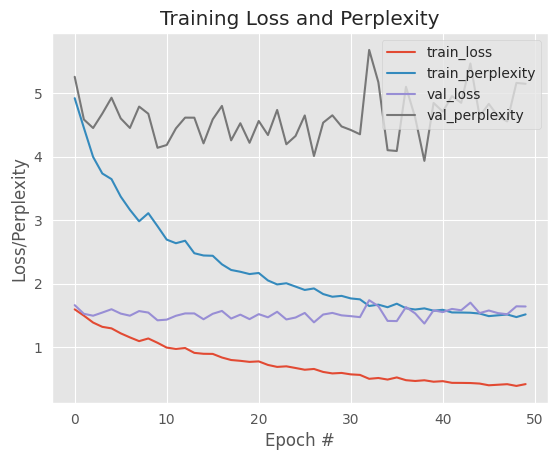

<Figure size 1000x1000 with 0 Axes>

In [ ]:
N = len(train_loss_list)

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), train_loss_list, label="train_loss")
plt.plot(np.arange(0, N), train_perplexity_list, label="train_perplexity")
plt.plot(np.arange(0, N), val_loss_list, label="val_loss")
plt.plot(np.arange(0, N), val_perplexity_list, label="val_perplexity")
plt.title("Training Loss and Perplexity")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Perplexity")
plt.legend(loc="upper right")
plt.figure(figsize = (10,10))
plt.show()

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import os

model_path = "/kaggle/working/BioMedBert/model"
tokenizer_path = "/kaggle/working/BioMedBert/tokenizer"
hub_model_id = "bombshelll/BioMedBert-finetuned-050525"

os.makedirs(model_path, exist_ok=True)
os.makedirs(tokenizer_path, exist_ok=True)

print("Saving model and tokenizer locally...")
trainer.save_model(model_path)
tokenizer.save_pretrained(tokenizer_path)
print("Model and tokenizer saved successfully!")

if not os.path.exists(model_path) or not os.path.exists(tokenizer_path):
    raise FileNotFoundError("Model or tokenizer not found in local path!")

print(f"Pushing model to {hub_model_id}...")
model = AutoModelForCausalLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
model.push_to_hub(hub_model_id)
tokenizer.push_to_hub(hub_model_id)
print(f"Model and tokenizer successfully pushed to {hub_model_id} on Hugging Face Hub!")

Saving model and tokenizer locally...


If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`


Model and tokenizer saved successfully!
Pushing model to bombshelll/BioMedBert-finetuned-050525...


README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


Model and tokenizer successfully pushed to bombshelll/BioMedBert-finetuned-050525 on Hugging Face Hub!


## Fine-tuning VisionEncoderDecoder BioMedBert + Encoder ViT

In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
tokenizer = AutoTokenizer.from_pretrained("bombshelll/BioMedBert-finetuned-050525")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/225k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/679k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

In [ ]:
train_dataset = ROCO_Dataset(df=train_df.reset_index().drop('index',axis =1),
                           tokenizer=tokenizer,feature_extractor= feature_extractor)
eval_dataset = ROCO_Dataset(df=validation_df.reset_index().drop('index',axis =1),
                           tokenizer=tokenizer,feature_extractor= feature_extractor)

In [ ]:
import warnings

warnings.filterwarnings("ignore")

from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    "google/vit-base-patch16-224-in21k",
    "bombshelll/BioMedBert-finetuned-050525",
    tie_encoder_decoder=True
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertLMHeadModel were not initialized from the model checkpoint at bombshelll/BioMedBert-finetuned-050525 and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.se

generation_config.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

In [ ]:
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

model.config.eos_token_id = tokenizer.sep_token_id
model.config.max_length = 80
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [ ]:
captioning_model = 'ViT_BioMedBert_ImageCaptioning'

training_args = Seq2SeqTrainingArguments(
    output_dir=captioning_model,
    logging_dir="/kaggle/working/ViT_BioMedBert_ImageCaptioning/logs",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    logging_strategy="steps",
    do_train=True,
    do_eval=True,
    logging_steps=50,
    save_steps=7000,
    num_train_epochs=20,
    overwrite_output_dir=True,
    save_total_limit=2,
    report_to="none"
)

trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,5.846500,7.643311
2,5.579300,9.673631
3,5.429300,11.878236
4,5.315500,12.398155
5,5.137800,14.610497
6,4.883900,14.840762
7,4.668000,13.845737
8,4.455600,15.598330
9,4.239200,14.777549
10,4.024600,16.934608


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 80, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be 

TrainOutput(global_step=7200, training_loss=4.148802157508002, metrics={'train_runtime': 2425.3174, 'train_samples_per_second': 23.7, 'train_steps_per_second': 2.969, 'total_flos': 1.0405388773857853e+19, 'train_loss': 4.148802157508002, 'epoch': 20.0})

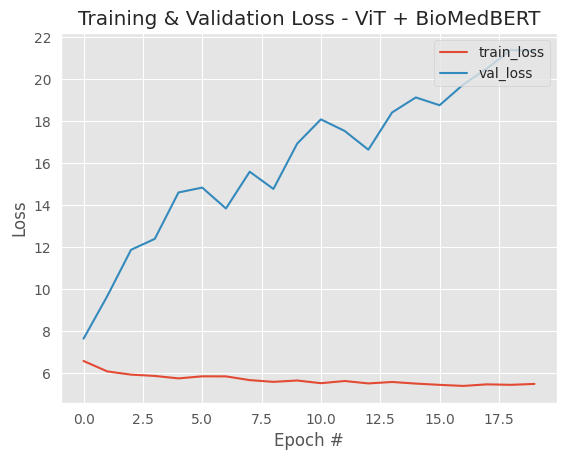

<Figure size 1000x1000 with 0 Axes>

In [ ]:
train_loss_list = []
val_loss_list = []

for log in trainer.state.log_history:
    if 'loss' in log and 'eval_loss' not in log:
        train_loss_list.append(log['loss'])
    if 'eval_loss' in log:
        val_loss_list.append(log['eval_loss'])

N = len(val_loss_list)

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), train_loss_list[:N], label="train_loss")
plt.plot(np.arange(0, N), val_loss_list, label="val_loss")
plt.title("Training & Validation Loss - ViT + BioMedBERT")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.figure(figsize=(10,10))
plt.show()


In [ ]:
trainer.save_model('/kaggle/working/ViT_BioMedBert_ImageCaptioning/model')
tokenizer.save_pretrained('/kaggle/working/ViT_BioMedBert_ImageCaptioning/tokenizer')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 80, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be 

('/kaggle/working/ViT_BioMedBert_ImageCaptioning/tokenizer/tokenizer_config.json',
 '/kaggle/working/ViT_BioMedBert_ImageCaptioning/tokenizer/special_tokens_map.json',
 '/kaggle/working/ViT_BioMedBert_ImageCaptioning/tokenizer/vocab.txt',
 '/kaggle/working/ViT_BioMedBert_ImageCaptioning/tokenizer/added_tokens.json',
 '/kaggle/working/ViT_BioMedBert_ImageCaptioning/tokenizer/tokenizer.json')

## Inference

The following encoder weights were not tied to the decoder ['vision_encoder_decoder/pooler', 'vision_encoder_decoder/embeddings', 'vision_encoder_decoder/layernorm', 'vision_encoder_decoder/encoder']
The following encoder weights were not tied to the decoder ['vision_encoder_decoder/pooler', 'vision_encoder_decoder/embeddings', 'vision_encoder_decoder/layernorm', 'vision_encoder_decoder/encoder']
The following encoder weights were not tied to the decoder ['vision_encoder_decoder/pooler', 'vision_encoder_decoder/embeddings', 'vision_encoder_decoder/layernorm', 'vision_encoder_decoder/encoder']


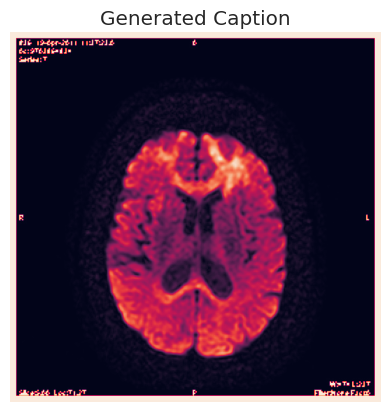

Generated Caption: axial abnormal brain mri normal the a an t2 initial magnetic diffusion coronal half small example no 75 fluid transverse blood iv first cns there t1
Ground Truth Caption:  Brain magnetic resonance imaging (MRI) after gadolinium injection showed an image in the axial (FLAIR sequence) showing hyper-intensity lesions in the white matter of the frontal lobes. There is no signal abnormality of the cortex. Note that there is no mass effect on the ventricular cavities or midline structures.



In [ ]:
from transformers import VisionEncoderDecoderModel, AutoTokenizer, ViTFeatureExtractor
from PIL import Image
import requests
import torch

model = VisionEncoderDecoderModel.from_pretrained('/kaggle/working/ViT_BioMedBert_ImageCaptioning/model')
tokenizer = AutoTokenizer.from_pretrained('/kaggle/working/ViT_BioMedBert_ImageCaptioning/tokenizer')
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def predict_caption(image_path):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((IMAGE_TARGET_SIZE, IMAGE_TARGET_SIZE))

    pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)

    output_ids = model.generate(pixel_values,
                                max_length=80,
                                num_beams=4,
                                early_stopping=True)

    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return caption

sample_image_path = test_df.iloc[0]['images']
predicted_caption = predict_caption(sample_image_path)

img = Image.open(sample_image_path)
plt.imshow(img)
plt.axis('off')
plt.title("Generated Caption")
plt.show()

print("Generated Caption:", predicted_caption)
print("Ground Truth Caption:", test_df.iloc[0]['captions'])

## Inference & Load Fine-tuned Model from HuggingFace

In [ ]:
from transformers import VisionEncoderDecoderModel, AutoTokenizer, ViTFeatureExtractor
from PIL import Image
import torch

model_id = "bombshelll/ViT_BioMedBert_Captioning_ROCO"

model = VisionEncoderDecoderModel.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)
feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

config.json:   0%|          | 0.00/5.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/897M [00:00<?, ?B/s]

The following encoder weights were not tied to the decoder ['vision_encoder_decoder/pooler', 'vision_encoder_decoder/embeddings', 'vision_encoder_decoder/layernorm', 'vision_encoder_decoder/encoder']
The following encoder weights were not tied to the decoder ['vision_encoder_decoder/pooler', 'vision_encoder_decoder/embeddings', 'vision_encoder_decoder/layernorm', 'vision_encoder_decoder/encoder']
The following encoder weights were not tied to the decoder ['vision_encoder_decoder/pooler', 'vision_encoder_decoder/embeddings', 'vision_encoder_decoder/layernorm', 'vision_encoder_decoder/encoder']


generation_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/706k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768

In [ ]:
def generate_caption(image_path):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((224, 224))
    pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)
    output_ids = model.generate(pixel_values, max_length=80, num_beams=4, early_stopping=True)
    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return caption

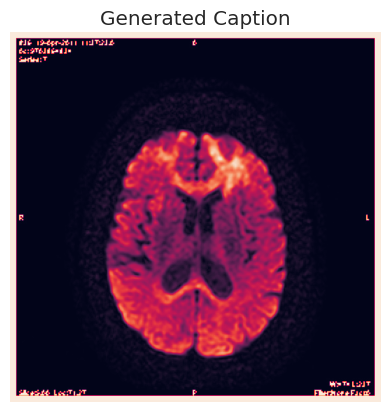

Generated Caption: magnetic resonance imaging of brain with diffusion weighted imaging sequence showing multiple infarctions in the left parieto - occipital region with small hemorrhage in the right pari
Ground Truth:  Brain magnetic resonance imaging (MRI) after gadolinium injection showed an image in the axial (FLAIR sequence) showing hyper-intensity lesions in the white matter of the frontal lobes. There is no signal abnormality of the cortex. Note that there is no mass effect on the ventricular cavities or midline structures.



In [ ]:
import matplotlib.pyplot as plt

sample_image_path = test_df.iloc[0]['images']
caption = generate_caption(sample_image_path)

plt.imshow(Image.open(sample_image_path))
plt.axis('off')
plt.title("Generated Caption")
plt.show()

print("Generated Caption:", caption)
print("Ground Truth:", test_df.iloc[0]['captions'])